<div align=center><font size=5>A Price Prediction Model for Airbnb Houses Based on Text Mining and Picture Analysis</font></div>

<div align=center><font size=4>Jingwei Dai</font></div>

<div align=center><font size=4>Contents</font></div>

<font size=4>Part 1. Background</font>

<font size=4>Part 2. Text Mining of Reviews: Topic Modelling, LDA Model, and Sentiment Analysis</font>

<font size=4>Part 3. Picture Analysis: K-Means Clustering, Convolutional Neural Network, and OpenCV, Detecting the Color Tone of the Pictures</font>

<font size=4>Part 4. Regression Analysis</font>



## Background


### Background


This data documents the listings of airbnb houses in New York City on Sep. 2nd, 2021 and their characteristics, including picture urls, review details, prices, potential demand in the next month, etc. I intend to utilize the house attributes to predict their listing prices, serving as a model for hosts to price their properties.

In [39]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import names
from nltk.corpus import wordnet as wn
import gensim
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [37]:
nltk.download('stopwords')
nltk.download('words')
nltk.download('names')
nltk.download('wordnet')
nltk.download('vader_lexicon')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/elft21/jietechen3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /home/elft21/jietechen3/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     /home/elft21/jietechen3/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/elft21/jietechen3/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/elft21/jietechen3/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Text Mining of Reviews: Topic Modelling, LDA Model, and Sentiment Analysis

In this section, we would do natural language processing. We employ topic modeling methods and LDA Model to do sentiment analysis for the reviews of Airbnb houses, so as to obtain how previous renters view and comment the houses and the hosts. We would generate a variable that quanitifies the overall attitude of each comment, composing from their positive, negative, and neural attitude respectively. Then we would use the outcome as an important variable for later regression and comprehensive analysis, so as to represent and quantify the effect of Word-of-Mouth on prices.

### Data Cleaning

#### Load Datasets

In [5]:
reviews = pd.read_csv('reviews.csv')
listings = pd.read_csv('listings.csv', low_memory = False,encoding = "ISO-8859-1")
# select columns in reviews df that are useful later
reviews0 = reviews[['listing_id', 'comments']]
reviews1 = reviews0.dropna(axis=0, how='any')
reviews2 = reviews1.rename(columns = {'listing_id':'id'})
# select columns in listings df that are useful later
listings0 = listings[['id', 'host_is_superhost', 'price', 'number_of_reviews', 'review_scores_rating']]
listings1 = listings0.dropna(axis=0, how='any')

In [7]:
dfmerge = pd.merge(reviews2, listings1, on = 'id', how = 'left')
dfmerge.head()

,id,comments,host_is_superhost,price,number_of_reviews,review_scores_rating
0,2595,Notre séjour de trois nuits.\r<br/>Nous avons ...,f,$150.00,48.0,4.7
1,2595,Great experience.,f,$150.00,48.0,4.7
2,2595,I've stayed with my friend at the Midtown Cast...,f,$150.00,48.0,4.7
3,2595,"We've been staying here for about 9 nights, en...",f,$150.00,48.0,4.7
4,2595,We had a wonderful stay at Jennifer's charming...,f,$150.00,48.0,4.7


#### Remove Abnormal Comments

In [8]:
#Remove AutoReview
def autoreview(x):
    if 'an automated posting' in x:
        return '1'
    else:
        return '0'
dfmerge['autoreview'] = dfmerge['comments'].apply(autoreview)

In [9]:
#Remove non-English comments
# get nonenglish stopwords
stopwords_en = set(stopwords.words('english')) #english stopwords
stopwords_noten = set(stopwords.words()) - stopwords_en
# get english vocab
en_vocab = set(w.lower() for w in nltk.corpus.words.words())
# get nonenglish stopwords that are also not english words
stopwords_justnoten = set(stopwords_noten - stopwords_noten.intersection(en_vocab))

In [12]:
tokenizer = RegexpTokenizer(r'\w+')
def isen(x):
    tokens = set(tokenizer.tokenize(x.lower()))
    if len(tokens & stopwords_justnoten) == 0:
        return '1'
    else:
        return '0'
dfmerge['isen'] = dfmerge['comments'].apply(isen)    

In [66]:
dfmergeClean = dfmerge.loc[(dfmerge['autoreview']=='0') & (dfmerge['isen']=='1')]

In [67]:
#remove br tags
dfmergeClean['comments'] = dfmergeClean['comments'].str.replace('<br/>',"")
dfmergeClean['comments'] = dfmergeClean['comments'].str.replace('</br>',"")
dfmergeClean['comments'] = dfmergeClean['comments'].str.replace('<br>',"")

In [68]:
#Remove URLs
reviews_freeurl = []
for comment in dfmergeClean['comments']:
    review = re.sub('URL HIDDEN', '', comment)
    reviews_freeurl.append(review)

In [69]:
#Perform tokenization, removal of names and stopwords, change into lower case words, and lemmatisation
from nltk.corpus import names
tokenizer = RegexpTokenizer(r'\w+')
stopwordsEn = set(stopwords.words('english'))
names = set(names.words())
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma   

In [70]:
dataCleaned = []
for review in reviews_freeurl:
    tokens = tokenizer.tokenize(review) # tokenize
    tokens = [w.lower() for w in tokens if w not in names and len(w)>1]   # remove personal names, remove 1-char tokens, lowercase
    tokens = [get_lemma(w) for w in tokens if w not in stopwordsEn]      # remove english stopwords, lemmatize
    dataCleaned.append(tokens)

In [71]:
dfmergeClean.loc[:, 'dataCleaned'] = dataCleaned
dfmergeClean['review_len'] = dfmergeClean['dataCleaned'].apply(len)

In [72]:
dfmergeClean.head(10)

,id,comments,host_is_superhost,price,number_of_reviews,review_scores_rating,autoreview,isen,dataCleaned,review_len
1,2595,Great experience.,f,$150.00,48.0,4.7,0,1,"[great, experience]",2
2,2595,I've stayed with my friend at the Midtown Cast...,f,$150.00,48.0,4.7,0,1,"[stay, friend, midtown, castle, six, days, lov...",45
3,2595,"We've been staying here for about 9 nights, en...",f,$150.00,48.0,4.7,0,1,"[stay, night, enjoy, center, city, never, slee...",30
4,2595,We had a wonderful stay at Jennifer's charming...,f,$150.00,48.0,4.7,0,1,"[wonderful, stay, charm, apartment, organize, ...",12
5,2595,Hi to everyone!\rWould say our greatest compli...,f,$150.00,48.0,4.7,0,1,"[hi, everyone, would, say, greatest, complimen...",50
6,2595,"Jennifer was very friendly and helpful, and he...",f,$150.00,48.0,4.7,0,1,"[friendly, helpful, place, exactly, advertise,...",14
7,2595,This apartment is like a real castle old and u...,f,$150.00,48.0,4.7,0,1,"[apartment, like, real, castle, old, unique, a...",110
8,2595,Jennifer's place was in a great midtown locati...,f,$150.00,48.0,4.7,0,1,"[place, great, midtown, location, close, subwa...",31
9,2595,Jennifer is a very nice host. Everything is cl...,f,$150.00,48.0,4.7,0,1,"[nice, host, everything, clean, really, take, ...",11
10,2595,This is a cute studio in a wonderful location ...,f,$150.00,48.0,4.7,0,1,"[cute, studio, wonderful, location, quirky, in...",32


### Topic Modeling and Latent Dirichlet Allocation (LDA)

Topic modeling is a type of statistical modeling for discovering the abstract “topics” that occur in a collection of documents. Latent Dirichlet Allocation (LDA) is an example of topic model and is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions. Reference: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24.

The reason that we why we employ this NLP method is that it has good performance for modeling the topics and could help pave the basis for sentiment analysis later. Also, as we do not have training sets with tag labels, this model would be more proper than deep learning models such as LSTM which requires training set tags.

In [73]:
# we would remove the reviews with fewer than 10 tokens
dfLDA = dfmergeClean[dfmergeClean['review_len'] >= 10]

In [74]:
dic= corpora.Dictionary(dfLDA['dataCleaned'])
# We would filter out words that show in < 15 reviews, or display > 75% of the reviews as they would not be helpful
dic.filter_extremes(no_below = 15, no_above = .75)
textsLDA = dfLDA['dataCleaned']
corpus = [dic.doc2bow(text) for text in textsLDA] 

In [75]:
#We would then train the LDA model
ldaAir = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = dic, num_topics = 9, passes = 20)

In [76]:
# print topic and words contributing to each topic
topics = ldaAir.print_topics(num_words = 10)
for topic in topics:  
    print(topic)

(0, '0.050*"great" + 0.042*"restaurant" + 0.033*"close" + 0.030*"location" + 0.026*"subway" + 0.025*"place" + 0.022*"walking" + 0.019*"distance" + 0.019*"apartment" + 0.018*"store"')
(1, '0.035*"parking" + 0.022*"place" + 0.020*"night" + 0.019*"street" + 0.019*"city" + 0.015*"day" + 0.013*"get" + 0.012*"nyc" + 0.012*"find" + 0.011*"spot"')
(2, '0.058*"walk" + 0.045*"10" + 0.042*"subway" + 0.033*"train" + 0.030*"station" + 0.029*"minutes" + 0.028*"manhattan" + 0.027*"away" + 0.025*"close" + 0.024*"square"')
(3, '0.066*"great" + 0.064*"stay" + 0.051*"place" + 0.040*"clean" + 0.034*"would" + 0.033*"location" + 0.032*"recommend" + 0.030*"host" + 0.026*"definitely" + 0.017*"super"')
(4, '0.040*"stay" + 0.034*"home" + 0.031*"airbnb" + 0.028*"place" + 0.023*"make" + 0.021*"host" + 0.021*"like" + 0.017*"amaze" + 0.017*"best" + 0.015*"feel"')
(5, '0.028*"room" + 0.013*"bed" + 0.013*"bathroom" + 0.012*"clean" + 0.011*"stay" + 0.010*"good" + 0.010*"nice" + 0.010*"place" + 0.009*"apartment" + 0.00

In [77]:
# save the LDA model so no need to train again
ldaAir.save('topicReview.model')

In [78]:
# load saved lda model and print topics
loading = LdaModel.load('topicReview.model')
# visualize the model and data
pyLDAvis.enable_notebook()
picLDAreview = pyLDAvis.gensim.prepare(ldaAir, corpus, dic)
picLDAreview

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.031947  0.167497       1        1  17.023918
5     -0.091243 -0.054932       2        1  16.492573
6     -0.008934  0.099335       3        1  13.767595
4     -0.196626  0.028347       4        1  11.448353
0      0.245937  0.070613       5        1  11.050395
7     -0.216443 -0.208274       6        1   9.308563
8     -0.005719  0.234946       7        1   8.122821
1     -0.020896 -0.160598       8        1   6.908685
2      0.325872 -0.176935       9        1   5.877097, topic_info=         Term           Freq          Total Category  logprob  loglift
12      great  388017.000000  388017.000000  Default  30.0000  30.0000
172        us  106776.000000  106776.000000  Default  29.0000  29.0000
232     check  110684.000000  110684.000000  Default  28.0000  28.0000
59       walk   80519.000000   80519.000000  Default  27.0000  27.0000
56     subway  105181.000000  105181.000000  Default  26.0000  26.0000
..        ...            ...            ...      ...      ...      ...
813     metro    7273.495558   15853.166386   Topic9  -4.9279   2.0550
243       get   12270.149920   97612.260597   Topic9  -4.4050   0.7603
81     locate    8366.576256   42956.245256   Topic9  -4.7879   1.1982
16   location    9251.353734  225536.799732   Topic9  -4.6874  -0.3596
45       good    8135.694990  125767.427178   Topic9  -4.8159   0.0959

[634 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
277       9  0.999977       10
2756      8  0.999549       11
344       9  0.999925       15
1005      9  0.999836       20
101       8  0.999670       24
...     ...       ...      ...
39        3  0.999973     york
1480      3  0.999480   yorker
2426      3  0.998953  yorkers
1320      8  0.999527    young
366       1  0.998551      zen

[1186 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 7, 5, 1, 8, 9, 2, 3])

From the dashboard, we can see that the most important factors that affect evaluations are feelings of the apartment, room conditions, 
as well as traffic covenience.

In [79]:
# save pyldavis results
pyLDAvis.save_html(picLDAreview,'visReview.html')

### Sentiment Analysis

In [80]:
sentimentReview = SentimentIntensityAnalyzer()
# calculate and get polarity scores for each line of review into a dictionary
polarity_scores = [sentimentReview.polarity_scores(review) for review in dfmergeClean['comments']]

In [81]:
dfmergeCleanSen = dfmergeClean.copy()
dfmergeCleanSen['compound'] = [score['compound'] for score in polarity_scores]
dfmergeCleanSen['negativity'] = [score['neg'] for score in polarity_scores]
dfmergeCleanSen['neutrality'] = [score['neu'] for score in polarity_scores]
dfmergeCleanSen['positivity'] = [score['pos'] for score in polarity_scores]

In [82]:
#dfmergeCleanSen.to_csv('reviewSentiment1.csv', index = False)

## Picture Analysis: K-Means Clustering, Convolutional Neural Network, and OpenCV, Detecting the Color Tone of the Pictures

This section would analyze the pictures posted by the hosts for the Airbnb houses. Our main goal in this section is to detect the overall color tone of the picture, as our hypothesis is that the color tone would affect the buyers' willingness to rent. In other words, we suppose warm and cool colors would have different impacts on consumers' feelings, so their desire to rent would diversify by this variable.

### Load Datasets, Define Useful Functions

In [83]:
from __future__ import print_function
import binascii
import struct
from PIL import Image
import numpy as np
import scipy
import scipy.misc
import scipy.cluster

import cv2, numpy as np
from sklearn.cluster import KMeans
import urllib.request
import requests 

In [84]:
#function for getting main color
def get_dominant_color(pil_img):
    img = pil_img.copy()
    img.convert("RGB")
    img.resize((1, 1), resample=0)
    dominant_color = img.getpixel((0, 0))
    return dominant_color

def visualize_colors(cluster, centroids):
    # Get the number of different clusters, create histogram, and normalize
    labels = np.arange(0, len(np.unique(cluster.labels_)) + 1)
    (hist, _) = np.histogram(cluster.labels_, bins = labels)
    hist = hist.astype("float")
    hist /= hist.sum()

    # Create frequency rect and iterate through each cluster's color and percentage
    rect = np.zeros((50, 300, 3), dtype=np.uint8)
    colors = sorted([(percent, color) for (percent, color) in zip(hist, centroids)])
    start = 0
    for (percent, color) in colors:
        print(color, "{:0.2f}%".format(percent * 100))
        end = start + (percent * 300)
        cv2.rectangle(rect, (int(start), 0), (int(end), 50), \
                      color.astype("uint8").tolist(), -1)
        start = end
    return rect

### Apply K-Means Clustering to the Pictures and then Break the Integrated Colors to three Layers: R, G, B

In [85]:
NUM_CLUSTERS = 5
badlistid = []
Rlist = []
Glist = []
Blist = []

In [87]:
df = listings.copy()

In [ ]:
#Due to disk storage constraint, we could not use all the pics, but only the first 9608 ones. However, since this is also a large volume, we suppose it should 
#be enough for us to draw conclusions.

In [89]:
for i in range(0,9609):
    response = requests.get(df['picture_url'][i])
    if response.status_code != 200: #could also check == requests.codes.ok
        badlistid.append(df['id'][i])
        continue
    urllib.request.urlretrieve(df['picture_url'][i],"pics/images{}.jpg".format(i))
    img = Image.open("pics/images{}.jpg".format(i))
    im = img.resize((200, 200),Image.ANTIALIAS) 
    ar = np.asarray(im)
    shape = ar.shape
    ar = ar.reshape(scipy.product(shape[:2]), shape[2]).astype(float)

    codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)

    vecs, dist = scipy.cluster.vq.vq(ar, codes)         # assign codes
    counts, bins = scipy.histogram(vecs, len(codes))    # count occurrences

    index_max = scipy.argmax(counts)                    # find most frequent
    print(i)
    peak = codes[index_max]
    Rlist.append(peak[0])
    Glist.append(peak[1])
    Blist.append(peak[2])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171


KeyboardInterrupt: 

In [ ]:
#merge R,G,B into the dataframe
mediationDicR = {'R':Rlist}
mediationdfR = pd.DataFrame(mediationDicR)
mediationDicG = {'G':Glist}
mediationdfG = pd.DataFrame(mediationDicG)
mediationDicB = {'B':Blist}
mediationdfB = pd.DataFrame(mediationDicB)
# get the subdataframe that does not contain missing pics and deleted profiles 
dfsub=df[0:9609]
dfsub1 = dfsub[~dfsub.id.isin(badlistid)]
dfsub2 = dfsub1.reset_index()
del dfsub2['index']
dfmergeR = pd.concat([dfsub2,mediationdfR],axis=1)
dfmergeG = pd.concat([dfmergeR,mediationdfG],axis=1)
dfmergeB = pd.concat([dfmergeG,mediationdfB],axis=1)
#define warm tone
dfmergeB['warm']=0
dfmergeB.loc[dfmergeB.R>dfmergeB.B,'warm']=1
dfmergeB['warm'].describe()


In [ ]:
#save it into a csv file. Since I have run the code before using my previous script, I did not run it again as it is very time-consuming.
#dfmerge1 = pd.read_csv('dfmerge.csv',encoding = "ISO-8859-1")

## Regression Analysis, Cross Validation, Extenstion, and Discussion

In this section, we would do regression analysis for the data, to predict the demand for the Airbnb houses.

### Data Preparation

In [91]:
#load the files
dfNew = pd.read_csv('dfmergeB.csv',encoding = "ISO-8859-1")
dfNew.head()

,id,listing_url,date,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,...,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,R,G,B,warm
0,2595,https://www.airbnb.com/rooms/2595,2021/9/2,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,https://a0.muscache.com/pictures/f0813a11-40b2...,2845,https://www.airbnb.com/users/show/2845,Jennifer,...,f,3,3,0,0,0.33,145.469269,118.032120,94.797308,1
1,3831,https://www.airbnb.com/rooms/3831,2021/9/2,"Whole flr w/private bdrm, bath & kitchen(pls r...","Enjoy 500 s.f. top floor in 1899 brownstone, w...",Just the right mix of urban center and local n...,https://a0.muscache.com/pictures/e49999c2-9fd5...,4869,https://www.airbnb.com/users/show/4869,LisaRoxanne,...,f,1,1,0,0,5.03,41.886548,43.327513,42.936160,0
2,5121,https://www.airbnb.com/rooms/5121,2021/9/2,BlissArtsSpace!,<b>The space</b><br />HELLO EVERYONE AND THANK...,NaN,https://a0.muscache.com/pictures/2090980c-b68e...,7356,https://www.airbnb.com/users/show/7356,Garon,...,f,1,0,1,0,0.54,149.949516,125.157799,45.749798,1
3,5136,https://www.airbnb.com/rooms/5136,2021/9/2,"Spacious Brooklyn Duplex, Patio + Garden",We welcome you to stay in our lovely 2 br dupl...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,7378,https://www.airbnb.com/users/show/7378,Rebecca,...,f,1,1,0,0,0.02,214.687595,195.996314,179.204118,1
4,5178,https://www.airbnb.com/rooms/5178,2021/9/2,Large Furnished Room Near B'way,Please don't expect the luxury here just a bas...,"Theater district, many restaurants around here.",https://a0.muscache.com/pictures/12065/f070997...,8967,https://www.airbnb.com/users/show/8967,Shunichi,...,f,1,0,1,0,3.64,178.576734,138.710742,101.362392,1


In [94]:
dfreview = pd.read_csv('reviewSentiment1.csv',encoding = "ISO-8859-1",lineterminator='\n')

In [95]:
dfreview.head()

,id,comments,host_is_superhost,price,number_of_reviews,review_scores_rating,autoreview,isen,dataCleaned,review_len,compound,negativity,neutrality,positivity
0,2595,Great experience.,f,$150.00,48.0,4.7,0,1,"['great', 'experience']",2,0.6249,0.000,0.196,0.804
1,2595,I've stayed with my friend at the Midtown Cast...,f,$150.00,48.0,4.7,0,1,"['stay', 'friend', 'midtown', 'castle', 'six',...",45,0.9248,0.016,0.793,0.192
2,2595,"We've been staying here for about 9 nights, en...",f,$150.00,48.0,4.7,0,1,"['stay', 'night', 'enjoy', 'center', 'city', '...",30,0.9229,0.000,0.808,0.192
3,2595,We had a wonderful stay at Jennifer's charming...,f,$150.00,48.0,4.7,0,1,"['wonderful', 'stay', 'charm', 'apartment', 'o...",12,0.9464,0.000,0.510,0.490
4,2595,Hi to everyone!\rWould say our greatest compli...,f,$150.00,48.0,4.7,0,1,"['hi', 'everyone', 'would', 'say', 'greatest',...",50,0.9869,0.000,0.729,0.271


In [96]:
#remove wrong lines whose ids are not digits
dfreview1 = dfreview[dfreview['id'].apply(lambda x: str(x).isdigit())]
#summarize all the reviews for each listing
dfreviewOverall = dfreview1.groupby(['id'])['compound'].mean().reset_index()
dfreviewP = dfreview1.groupby(['id'])['positivity'].mean().reset_index()
dfreviewN = dfreview1.groupby(['id'])['negativity'].mean().reset_index()
#make the id numeric
dfreviewOverall["id"] = pd.to_numeric(dfreviewOverall["id"])
dfreviewP["id"] = pd.to_numeric(dfreviewP["id"])
dfreviewN["id"] = pd.to_numeric(dfreviewN["id"])
#merge all of these summary dfs
dfmergeReview = pd.merge(dfNew,dfreviewOverall,on=['id'],how='left')
dfmergeReview = pd.merge(dfmergeReview,dfreviewP,on=['id'],how='left')
dfmergeReview = pd.merge(dfmergeReview,dfreviewN,on=['id'],how='left')

dfmergeReview.head()

,id,listing_url,date,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,R,G,B,warm,compound,positivity,negativity
0,2595,https://www.airbnb.com/rooms/2595,2021/9/2,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,https://a0.muscache.com/pictures/f0813a11-40b2...,2845,https://www.airbnb.com/users/show/2845,Jennifer,...,0,0,0.33,145.469269,118.032120,94.797308,1,0.784377,0.321614,0.018432
1,3831,https://www.airbnb.com/rooms/3831,2021/9/2,"Whole flr w/private bdrm, bath & kitchen(pls r...","Enjoy 500 s.f. top floor in 1899 brownstone, w...",Just the right mix of urban center and local n...,https://a0.muscache.com/pictures/e49999c2-9fd5...,4869,https://www.airbnb.com/users/show/4869,LisaRoxanne,...,0,0,5.03,41.886548,43.327513,42.936160,0,0.787390,0.322857,0.014694
2,5121,https://www.airbnb.com/rooms/5121,2021/9/2,BlissArtsSpace!,<b>The space</b><br />HELLO EVERYONE AND THANK...,NaN,https://a0.muscache.com/pictures/2090980c-b68e...,7356,https://www.airbnb.com/users/show/7356,Garon,...,1,0,0.54,149.949516,125.157799,45.749798,1,0.875212,0.360245,0.011327
3,5136,https://www.airbnb.com/rooms/5136,2021/9/2,"Spacious Brooklyn Duplex, Patio + Garden",We welcome you to stay in our lovely 2 br dupl...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,7378,https://www.airbnb.com/users/show/7378,Rebecca,...,0,0,0.02,214.687595,195.996314,179.204118,1,0.990100,0.266500,0.012500
4,5178,https://www.airbnb.com/rooms/5178,2021/9/2,Large Furnished Room Near B'way,Please don't expect the luxury here just a bas...,"Theater district, many restaurants around here.",https://a0.muscache.com/pictures/12065/f070997...,8967,https://www.airbnb.com/users/show/8967,Shunichi,...,1,0,3.64,178.576734,138.710742,101.362392,1,0.728178,0.263077,0.024644


In [100]:
# Remove the rows where the houses do not have a single reivew and rating
dfNew3 = dfmergeReview[dfmergeReview.compound.notna()]
dfNew3 = dfNew3[dfNew3['review_scores_rating'].notna()]

In [113]:
#remove '$'
dfNew3['price1'] = dfNew3['price'].str.extract('(\d+)', expand=False)
dfNew3['price1'] = dfNew3['price1'].astype(float)

### Linear Regression

In this and subsequent subsections, we would run regression analysis using marketing domain knowledge. We would firstly select important features, and then employ them for our regression analysis. Essentials that we select out include picture warm color tone (1 or 0), the overall review sentiment, number of reviews indicating past number of evaluations, star rating, minimum nights to stay for a booking, the number of capacity for accomodates, locations.

In [136]:
dfML = dfNew3[['price1','warm','compound','number_of_reviews','review_scores_rating','minimum_nights','accommodates','latitude','longitude']]
dfML

,price1,warm,compound,number_of_reviews,review_scores_rating,minimum_nights,accommodates,latitude,longitude
0,150.0,1,0.784377,48,4.70,30,1,40.75356,-73.98559
1,76.0,0,0.787390,408,4.46,1,3,40.68494,-73.95765
2,60.0,1,0.875212,50,4.52,30,2,40.68535,-73.95512
3,275.0,1,0.990100,2,5.00,5,4,40.66265,-73.99454
4,68.0,1,0.728178,490,4.21,2,2,40.76457,-73.98317
...,...,...,...,...,...,...,...,...,...
9598,105.0,1,0.799383,6,4.00,30,2,40.74697,-74.00327
9599,50.0,1,0.634957,8,4.00,30,2,40.72658,-73.97770
9600,160.0,1,0.862412,84,4.89,7,3,40.79614,-73.94867
9601,60.0,1,0.931175,4,5.00,1,3,40.72564,-73.94950


In [137]:
dfMLvalue = dfML.values
X = dfMLvalue[:,(1,2,3,4,5,6,7,8)]
Y = dfMLvalue[:,0] 
Y = Y.astype('int')

In [126]:
trainX, testX, trainY, testY = \
    model_selection.train_test_split(X, Y,
    train_size=0.7, test_size=0.3, random_state=4487)
print(trainX.shape)
print(testX.shape)

(5097, 8)
(2185, 8)


In [127]:
from sklearn import *
ols = linear_model.LinearRegression()
ols.fit(trainX,trainY)

LinearRegression()

In [128]:
ols.score(trainX,trainY)

0.3164353768209377

In [129]:
ols.predict(testX)

array([ 94.91705275,  88.54707943, 117.57577703, ..., 229.41623719,
        76.6384306 , 281.23694499])

In [125]:
def eval_predict(trueY, predY):
    MAE = metrics.mean_absolute_error(trueY, predY)
    RMSE = sqrt(metrics.mean_squared_error(trueY, predY))
    return RMSE, MAE

# function to make a scatter plot
def plot_scatter(testY, predY, titlestr):
    plt.scatter(testY, predY, s=1)
    plt.plot([min(testY),max(testY)], [min(testY),max(testY)], 'r-')
    plt.xlabel('true')
    plt.ylabel('prediction')
    r1,r2 = eval_predict(testY, predY)
    plt.title(titlestr + "\n(RMSE={:.3f}; MAE={:.3f})".format(r1,r2))
    plt.grid(True)

In [134]:
from numpy import *
trainerr={}; testerr={}

trainerr['err'] = eval_predict(trainY, ols.predict(trainX))
testerr['err']  = eval_predict(testY, ols.predict(testX))

print("train error: (RMSE,MAE)=", trainerr['err'] )
print("test error: (RMSE,MAE)=", testerr['err'] )

train error: (RMSE,MAE)= (87.73313282484548, 54.95473903630159)
test error: (RMSE,MAE)= (83.11870479116455, 52.90153210330531)


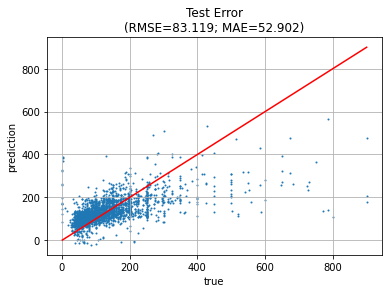

In [135]:
plot_scatter(testY, ols.predict(testX), 'Test Error')

### Random Forest

In [138]:
### Simple RF
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=5, random_state=0)
regr.fit(trainX, trainY)

RandomForestRegressor(max_depth=5, random_state=0)

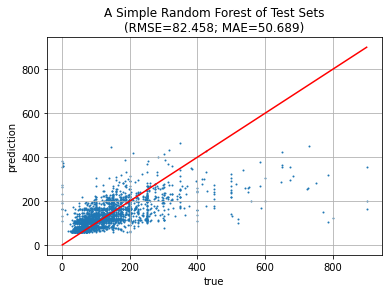

In [139]:
plot_scatter(testY, regr.predict(testX), 'A Simple Random Forest of Test Sets')

We can see that the models can predict the price well, demonstrating that our models can serve as good ones for Airbnb hosts to decide their listing price.